In [6]:
from matplotlib import pyplot as plt
# from google.colab import files
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib
import os

from PIL import Image
from tensorflow import keras
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.utils import timeseries_dataset_from_array
from tensorflow.keras.layers import Dense, Flatten, Softmax, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Activation, AveragePooling2D
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Rescaling, RandomWidth, RandomHeight, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.layers import SeparableConv2D, add, GlobalAveragePooling2D
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers


__<H1>Data Collection &#11088;<H1>__

In [7]:
!pip install gdown


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


__<h3>Create file directory for train, test, and validation data set</h3>__

In [12]:
import shutil
baseDir = "C:/Users/jeant/OneDrive - Chulalongkorn University/Desktop/Senior Project/Convertor code/Model/data"
os.mkdir(baseDir)

trainDir = os.path.join(baseDir, 'train')
os.mkdir(trainDir)

validationDir = os.path.join(baseDir, 'validation')
os.mkdir(validationDir)

testDir = os.path.join(baseDir, 'test')
os.mkdir(testDir)

trainHumanDir = os.path.join(trainDir, 'Human')
os.mkdir(trainHumanDir)

trainAIDir = os.path.join(trainDir, 'AI')
os.mkdir(trainAIDir)

validationHumanDir = os.path.join(validationDir, 'Human')
os.mkdir(validationHumanDir)

validationAIDir = os.path.join(validationDir, 'AI')
os.mkdir(validationAIDir)

testHumanDir = os.path.join(testDir, 'Human')
os.mkdir(testHumanDir)

testAIDir = os.path.join(testDir, 'AI')
os.mkdir(testAIDir)

print("Finished create file to receive all data !!")

Finished create file to receive all data !!


__<h2>👻 Copies data to each file 👻</h2>__

In [13]:
HumanDataDir = "C:/Users/jeant/OneDrive - Chulalongkorn University/Desktop/Senior Project/Dataset/Human Ver.2 Mix Pic/"
AIDataDir = "C:/Users/jeant/OneDrive - Chulalongkorn University/Desktop/Senior Project/Dataset/AI Ver.2 Mix Pic/"

In [15]:
# Copies AI voice Spectrogram 

fnames = ['AI{}.png'.format(i+1) for i in range(240)]
for fname in fnames:
  src = os.path.join(AIDataDir, fname)
  dst = os.path.join(trainAIDir, fname)
  shutil.copyfile(src, dst)


fnames = ['AI{}.png'.format(i+1) for i in range(240, 320)]
for fname in fnames:
  src = os.path.join(AIDataDir, fname)
  dst = os.path.join(validationAIDir, fname)
  shutil.copyfile(src, dst)


fnames = ['AI{}.png'.format(i+1) for i in range(320, 400)]
for fname in fnames:
  src = os.path.join(AIDataDir, fname)
  dst = os.path.join(testAIDir, fname)
  shutil.copyfile(src, dst)


# Copies Human voice Spectrogram 
  
fnames = ['Human{}.png'.format(i+1) for i in range(240)]
for fname in fnames:
  src = os.path.join(HumanDataDir, fname)
  dst = os.path.join(trainHumanDir, fname)
  shutil.copyfile(src, dst)


fnames = ['Human{}.png'.format(i+1) for i in range(240, 320)]
for fname in fnames:
  src = os.path.join(HumanDataDir, fname)
  dst = os.path.join(validationHumanDir, fname)
  shutil.copyfile(src, dst)


fnames = ['Human{}.png'.format(i+1) for i in range(320, 400)]
for fname in fnames:
  src = os.path.join(HumanDataDir, fname)
  dst = os.path.join(testHumanDir, fname)
  shutil.copyfile(src, dst)

In [16]:
print('total training AI voice images:', len(os.listdir(trainAIDir)))
print('total training Human voice images:', len(os.listdir(trainHumanDir)))
print('total validation AI voice images:', len(os.listdir(validationAIDir)))
print('total validation Human voice images:', len(os.listdir(validationHumanDir)))
print('total test AI voice images:', len(os.listdir(testAIDir)))
print('total test Human voice images:', len(os.listdir(testHumanDir)))

total training AI voice images: 300
total training Human voice images: 300
total validation AI voice images: 50
total validation Human voice images: 50
total test AI voice images: 50
total test Human voice images: 50


__<h3>Check Data Set</h3>__

In [17]:
trainSet = image_dataset_from_directory(
    trainDir,
    image_size = (224,224),
    batch_size = 64
)
valSet = image_dataset_from_directory(
    validationDir,
    image_size = (224,224),
    batch_size = 64
)
testSet = image_dataset_from_directory(
    testDir,
    image_size = (224,224),
    batch_size = 64
)

Found 600 files belonging to 2 classes.
Found 100 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


In [18]:
for data_batch, labels_batch in trainSet.take(1):
  print("data batch shape", data_batch.shape) # 64 224x224 3 c channels
  print("label batch shape", labels_batch.shape)
  print("labels_batch", labels_batch) # 0 AI, 1 Human

data batch shape (64, 224, 224, 3)
label batch shape (64,)
labels_batch tf.Tensor(
[1 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 0 1 1 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0
 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1], shape=(64,), dtype=int32)


__<h2>Call Back 👹</h2>__

In [19]:
early_stopping_cb = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model_checkpoint_cb1 = ModelCheckpoint('model_scratch/woaugment', monitor='val_loss',save_best_only=True, save_weights_only=True)
model_checkpoint_cb2 = ModelCheckpoint('model_scratch/waugment', monitor='val_loss',save_best_only=True, save_weights_only=True)
model_checkpoint_cb3 = ModelCheckpoint('model_feature_extraction/woaugment', monitor='val_loss',save_best_only=True, save_weights_only=True)
model_checkpoint_cb4 = ModelCheckpoint('model_feature_extraction/waugment', monitor='val_loss',save_best_only=True, save_weights_only=True)
model_checkpoint_cb5 = ModelCheckpoint('model_fine_tuning/woaugment', monitor='val_loss',save_best_only=True,save_weights_only=True)
model_checkpoint_cb6 = ModelCheckpoint('model_fine_tuning/waugment', monitor='val_loss',save_best_only=True,save_weights_only=True)
reduce_lr_cb = ReduceLROnPlateau(min_lr=0.001)

__<h2>Build Model 🫠</h2>__

__<h4>Let's Try Train from scratch</h4>__

In [20]:
def build_model_scratch1():
  model = Sequential()
  model.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=(224,224,3)))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(500, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [21]:
model = build_model_scratch1() # train without data Augmentation

model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
                loss='binary_crossentropy', 
                metrics=['accuracy']) # 0 1 learning rate?

history = model.fit(trainSet, epochs=20, validation_data=valSet, verbose=1,
                    callbacks=[model_checkpoint_cb1,reduce_lr_cb])

Epoch 1/20
10/10 [==============================] - 91s 8s/step - loss: 0.2121 - accuracy: 0.9183 - val_loss: 245.9328 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 84s 8s/step - loss: 0.0141 - accuracy: 0.9933 - val_loss: 116.1221 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 84s 8s/step - loss: 0.0248 - accuracy: 0.9933 - val_loss: 70.9115 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 85s 8s/step - loss: 0.0165 - accuracy: 0.9967 - val_loss: 29.9583 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/20
10/10 [==============================] - 85s 8s/step - loss: 0.0115 - accuracy: 0.9950 - val_loss: 2.0478 - val_accuracy: 0.6900 - lr: 0.0010
Epoch 6/20
10/10 [==============================] - 78s 8s/step - loss: 0.0096 - accuracy: 0.9950 - val_loss: 13.8593 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/20
10/10 [==============================] - 75s 7s/step - loss: 0.0

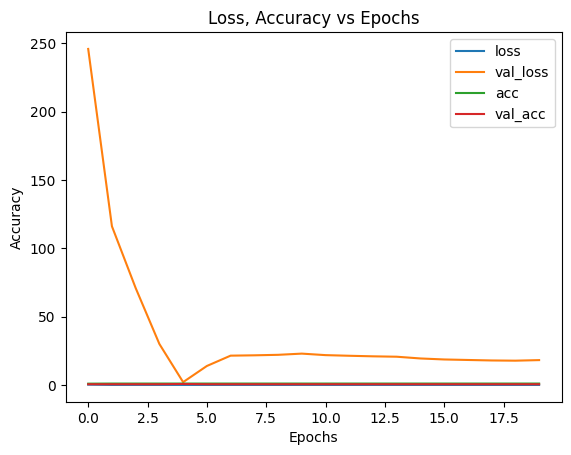

In [22]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['accuracy'], label = 'acc')
plt.plot(history.history['val_accuracy'], label = 'val_acc')
plt.title('Loss, Accuracy vs Epochs')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [23]:
loss, acc = model.evaluate(testSet)
print('test_oss:', loss)
print('test_acc:', acc)

2/2 [==============================] - 2s 544ms/step - loss: 17.8151 - accuracy: 0.5000
test_oss: 17.815074920654297
test_acc: 0.5


In [32]:
# data augmentation
datagen = ImageDataGenerator(
rescale=1./255, 
rotation_range=15, # random rotation up to x degrees
width_shift_range=0.1, # 
height_shift_range=0.1,
horizontal_flip=True, # horizontal flip
vertical_flip=False # vartival flip
)

# prepare iterator
it_train = datagen.flow_from_directory(
   trainDir,
   target_size=(224, 224),
   batch_size=64,
   class_mode='binary') # binary class

Found 600 images belonging to 2 classes.


In [ ]:
# train with data augmentation
# model = build_model()

# model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
#                loss='binary_crossentropy',
#                metrics=['accuracy'])

# history = model.fit(it_train, epochs=50, validation_data=valSet, verbose=1,steps_per_epoch=2000//64,
#                    callbacks=[model_checkpoint_cb2,reduce_lr_cb])

In [33]:
data_augmentation = Sequential(
  [
    RandomRotation(0.1),
    RandomZoom(0.2),
    RandomFlip('horizontal')
  ]
)

# training from scratch
def build_model_scratch2():
  model = Sequential()
  model.add(Input((224,224,3)))
  model.add(data_augmentation) # 
  model.add(Rescaling(1./255)) #
  
  model.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  # model.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.3))

  # model.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
  # model.add(MaxPooling2D(pool_size=2))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.3))

  # model.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.3))
  
  # model.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
  # model.add(MaxPooling2D(pool_size=2))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.3))

  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(500, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [34]:
# train with data augmentation
model = build_model_scratch2()
model.summary()
model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# history = model.fit(trainSet, epochs=10, validation_data=valSet, verbose=1,
#                     callbacks=[model_checkpoint_cb2,reduce_lr_cb])

history = model.fit(trainSet, epochs=20, validation_data=valSet, verbose=1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_24 (Ba  (None, 224, 224, 32)      128       
 tchNormalization)                                               
                                                                 
 dropout_21 (Dropout)        (None, 224, 224, 32)      0         
                                                                 
 conv2d_19 (Conv2D)          (None, 224, 224, 32)      9248      
                                                      

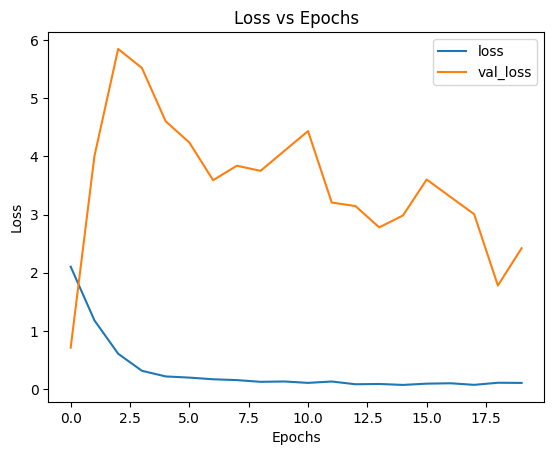

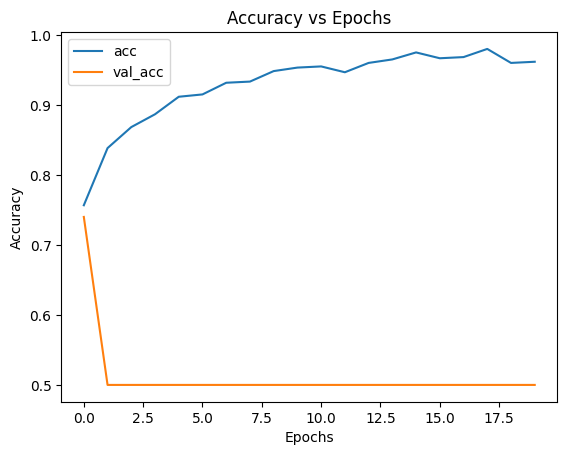

In [38]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Loss vs Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label = 'acc')
plt.plot(history.history['val_accuracy'], label = 'val_acc')
plt.title('Accuracy vs Epochs')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

<H1>🤮🫠<H1>

In [36]:
# test set
loss, acc = model.evaluate(testSet)
print('test_oss:', loss)
print('test_acc:', acc)

2/2 [==============================] - 1s 376ms/step - loss: 2.3620 - accuracy: 0.5000
test_oss: 2.3619771003723145
test_acc: 0.5


In [30]:
model = VGG16(weights="imagenet", include_top=True,input_shape=(224,224,3))
model.summary()

553467096/553467096 [==============================] - 25s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
# load an image from a file
image = load_img('S__5988354.jpg',target_size=(224,224))
# convert the image pixels to a numpy array
image = img_to_array(image)
plt.imshow(image/255)

# reshape data for the model
image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
# print(image.shape) #(1, 224, 224, 3)
# BGR and zero-centered
image = preprocess_input(image)
image